# Pneumonia Prediction using Convulational Neural Network
The images trained, tested and validated for the neural network are chest X-Ray images. The implementation of clinical-decision support algorithms for medical imaging faces challenges with reliability and interpretability. Here, I establish a diagnostic tool based on a deep-learning framework for the screening of patients with common treatable blinding retinal diseases.

In [1]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 K

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd
import gradio

Data Preprocessing:

Getting training, validation and testing dataset

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) #reshaping images to preferred size
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)

In [4]:
train = get_data('/content/drive/MyDrive/archive/chest_xray/train')
test = get_data('/content/drive/MyDrive/archive/chest_xray/test')
val = get_data('/content/drive/MyDrive/archive/chest_xray/val')

<ipython-input-3-c95eb64dc460>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


Splitting x and y labels of training, validation and testing dataset

In [5]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)


In [6]:
positives = []
negatives = []

for i in range(len(y_train)):
  if y_train[i]:
    positives.append(x_train[i])
  else:
    negatives.append(x_train[i])

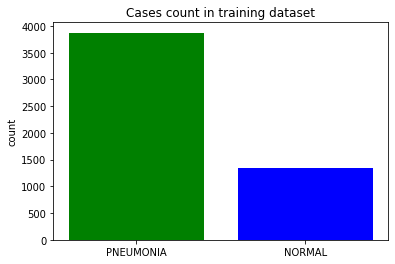

In [7]:
plt.bar(labels, [len(negatives), len(positives)], color = ["green", "blue"])
plt.title("Cases count in training dataset")
plt.ylabel("count")
plt.show()

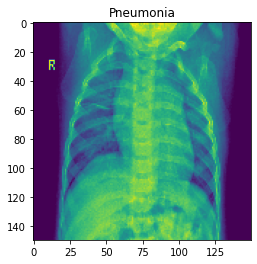

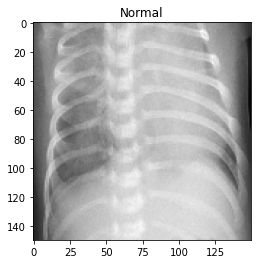

In [8]:
plt.imshow(positives[0])
plt.title("Pneumonia")
plt.show()

plt.imshow(negatives[4], cmap = 'gray')
plt.title("Normal")
plt.show()

Performing a grayscale normalization to reduce the efffect of illumination differences

In [9]:
#Normalize the data
x_train = np.array(x_train)/255 #reduce the values only in 0 or 1
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

Resizing the data for CNN training and testing

In [10]:
#resize data for deep learning

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


In [11]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

# Data augmentation: 
In order to avoid overfitting problem, we can expand artificially our dataset. This can be done by altering the training data with small transformations to reproduce the variations.
Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=30, #randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, #randomly zoom image
        width_shift_range=0.1, #randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1, #randomly shift images vertically (fraction of total height)
        horizontal_flip=True, #randomly flip images
        vertical_flip=False) #randomly flip images

datagen.fit(x_train)

In [13]:
model = Sequential()
model.add(Conv2D(32, (3,3) , strides = 1, padding = 'same', activation = 'relu', input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(Conv2D(64, (3,3) , strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(Conv2D(64, (3,3) , strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(Conv2D(128, (3,3) , strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(Conv2D(256, (3,3) , strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = "rmsprop", loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [14]:
model.compile(optimizer = "rmsprop",
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
#model.summary()

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose = 1,
                                            factor = 0.3,
                                            min_lr = 0.000001)

In [16]:
history = model.fit(datagen.flow(x_train, y_train, batch_size = 32),
                    epochs = 10,
                    validation_data = datagen.flow(x_val, y_val),
                    callbacks = learning_rate_reduction)

Epoch 1/10
163/163 [==============================] - 28s 100ms/step - loss: 0.5329 - accuracy: 0.8351 - val_loss: 49.5828 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 14s 85ms/step - loss: 0.2724 - accuracy: 0.8997 - val_loss: 58.7967 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9195
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 14s 84ms/step - loss: 0.2143 - accuracy: 0.9195 - val_loss: 33.0701 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 14s 84ms/step - loss: 0.1586 - accuracy: 0.9454 - val_loss: 29.5490 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9540
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [=====================

In [17]:
model.save_weights('/content/drive/MyDrive/ColabNotebooks/saved_model_ai/pneumoniadetection')

# Evaluation Metrics

In [18]:
print("Loss of the model: ", model.evaluate(x_test, y_test)[0])
print("Accuracy of the model: ", model.evaluate(x_test, y_test)[1]*100, "%")

20/20 [==============================] - 0s 14ms/step - loss: 0.2484 - accuracy: 0.9054
Loss of the model:  0.24835960566997528
20/20 [==============================] - 0s 14ms/step - loss: 0.2484 - accuracy: 0.9054
Accuracy of the model:  90.54487347602844 %


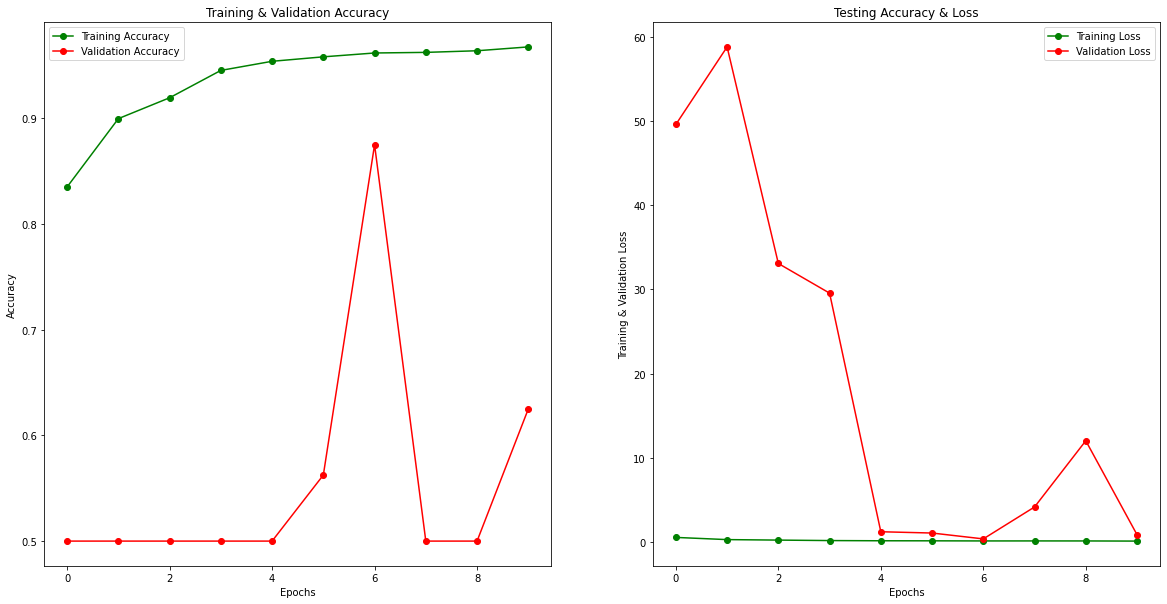

In [19]:
epochs  =list(range(10))
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'g-o', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [20]:
predictions = model.predict(x_test)
for i in range(len(predictions)):
  predictions[i] = 1 if predictions[i] > 0.5 else 0

20/20 [==============================] - 1s 12ms/step


In [21]:
print(classification_report(y_test,
                            predictions,
                            target_names = ['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.92      0.92       390
   Normal (Class 1)       0.86      0.89      0.88       234

           accuracy                           0.91       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624



# Confusion Matrix
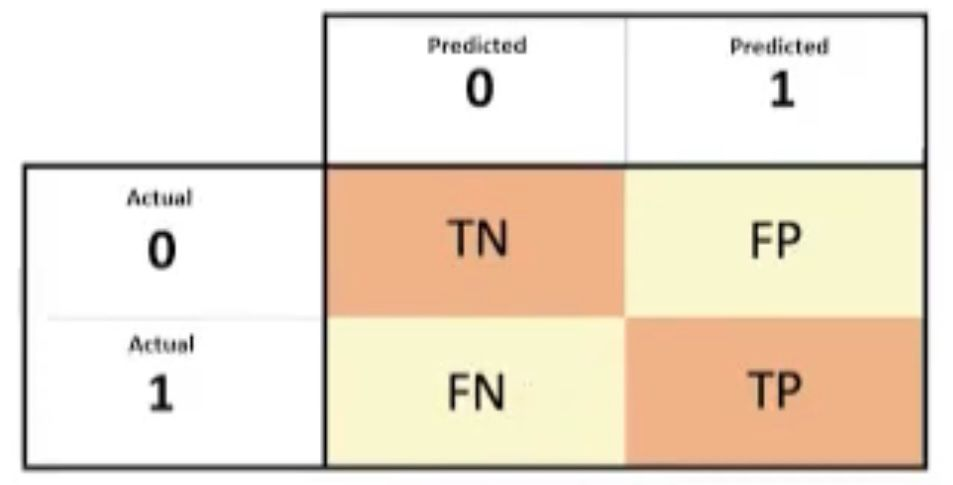


In [24]:
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, index = ['0','1'], columns = ['0','1'])
cm

,0,1
0,357,33
1,26,208


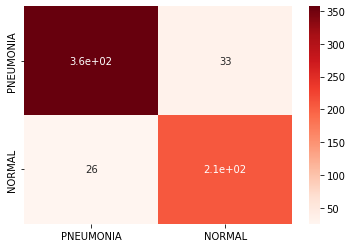

In [25]:
sns.heatmap(cm, cmap='Reds', annot = True, xticklabels = labels,yticklabels = labels)
plt.show()

In [37]:
def pneumoniaPrediction(img):
  img = np.array(img)/255
  img = img.reshape(-1, 150, 150, 1)
  isPneumonic = model.predict(img)[0]
  imgClass = "Normal" if isPneumonic<0.5 else "Pneumonic"
  return imgClass

In [38]:
pr = model.predict(x_test)
for i in range(len(pr)):
  if pr[i]>0.5:
    pr[i]=1
  else:
    pr[i]=0

20/20 [==============================] - 0s 11ms/step


In [39]:
img = gradio.inputs.Image(shape=(150, 150))
label = gradio.outputs.Label(num_top_classes=1)

In [ ]:
interface = gradio.Interface(fn = pneumoniaPrediction,
                            title = "Pneumonia Detection using Chest X-Ray",
                            inputs = img,
                            outputs = label,
                            interpretation = "default")
interface.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://b87e6953260c85536e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 394, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1075, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 884, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-37-1910e74b6e23>", line 2, in pneumoniaPrediction
    img = np.array(img)/255
TypeError: unsupported operand 

1/1 [==============================] - 0s 21ms/step
